In [1]:
import sys
import os
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from collections import Counter
import numpy as np
import random

from bs4 import BeautifulSoup
import pandas as pd
import requests

from time import sleep

import enchant
d = enchant.Dict("en_US")

from tqdm import tqdm
import string

In [7]:
path = "data/raw/"
essay_file = path+ "asap-aes/train.tsv"

i=0

essayList = []
with open(essay_file) as f:
    for line in f:
        if line.startswith("Id"):
            continue
        splitLine = line.strip().split("\t")
        scores = map(int, splitLine[2:4])
        avgscore = sum(scores)/2
        essay = sent_tokenize(splitLine[4])
        for sent in essay:
            essayList.append([sent, avgscore])
    

FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/asap-aes/train.tsv'

In [10]:
path = "data/raw/"
short_answer_file = path+ "asap-sas/train.tsv"

i=0

dataList = []
with open(short_answer_file) as f:
    for line in f:
        if line.startswith("Id"):
            continue
        splitLine = line.strip().split("\t")
        scores = map(int, splitLine[2:4])
        avgscore = sum(scores)/2
        essay = sent_tokenize(splitLine[4])
        for sent in essay:
            dataList.append([sent, avgscore])
    

In [11]:
highScores = []
lowScores = []
for data in dataList:
    if len(word_tokenize(data[0])) > 20:
        continue
    if data[1] >= 2:
        highScores.append(data[0])
    if data[1] ==0:
        lowScores.append(data[0])
    

In [40]:
import csv

with open('sas_high.csv', 'w', newline='\n') as f:
    writer = csv.writer(f)
    writer.writerows(highScores)
    

with open('sas_low.csv', 'w', newline='\n') as f:
    writer = csv.writer(f)
    writer.writerows(lowScores)

In [42]:
Counter([x[1] for x in dataList])

Counter({1.0: 11279,
         0.0: 11879,
         2.0: 11669,
         0.5: 2255,
         3.0: 2247,
         2.5: 510,
         1.5: 3216})

In [131]:

random.shuffle(cleanLow)
train_low = cleanLow[:5000]
test_low = cleanLow[5500:]
dev_low = cleanLow[5000:5500]

random.shuffle(cleanHigh)
train_high = cleanHigh[:5000]
test_high = cleanHigh[5500:]
dev_high = cleanHigh[5000:5500]

In [23]:
import string

def clean(data_list):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    newList = []
    for sent in data_list:
        if len(sent) < 40:
            continue
        if '^' in sent:
            continue
        #sent = re.sub(r'\d+', '', sent)
        

        #sent = re.sub('['+string.punctuation+']', '', sent)
        sent = sent.lower()
        
        newList.append(sent + '\n')
    
    return newList
        

In [24]:
cleanLow = clean(lowScores)

In [25]:
cleanHigh = clean(highScores)

In [26]:
len(cleanLow)

6057

In [27]:
len(cleanHigh)

7221

In [28]:
with open('sas_data.1', 'w') as f:
    f.writelines(cleanHigh)

In [29]:
with open('sas_data.0', 'w') as f:
    f.writelines(cleanLow)

In [106]:
high_label = [1 for x in cleanHigh]
low_label = [0 for x in cleanLow]

In [111]:
labels = high_label + low_label

In [113]:
all_data = cleanHigh + cleanLow

In [114]:
import random

c = list(zip(all_data, labels))

random.shuffle(c)

shuff_data, shuff_labels = zip(*c)


In [119]:
with open('../text_style_transfer/model/data/sas_data', 'w') as f:
    retokenized = map(lambda x: ' '.join(word_tokenize(x)) + '\n', shuff_data)
    f.writelines(retokenized)
    
# with open('../text_style_transfer/model/data/sas.test.1', 'w') as f:
#     retokenized = map(lambda x: ' '.join(word_tokenize(x)) + '\n', test_high)
#     f.writelines(retokenized)
    
# with open('../text_style_transfer/model/data/sas.dev.1', 'w') as f:
#     retokenized = map(lambda x: ' '.join(word_tokenize(x)) + '\n', dev_high)
#     f.writelines(retokenized)

with open('../text_style_transfer/model/data/sas_labels', 'w') as f:
    f.writelines(map(lambda x: str(x) + '\n', shuff_labels))

In [132]:


with open('../language-style-transfer/data/sas.train.1', 'w') as f:
    retokenized = map(lambda x: ' '.join(word_tokenize(x)) + '\n', train_high)
    f.writelines(retokenized)
    
with open('../language-style-transfer/data/sas.test.1', 'w') as f:
    retokenized = map(lambda x: ' '.join(word_tokenize(x)) + '\n', test_high)
    f.writelines(retokenized)
    
with open('../language-style-transfer/data/sas.dev.1', 'w') as f:
    retokenized = map(lambda x: ' '.join(word_tokenize(x)) + '\n', dev_high)
    f.writelines(retokenized)

with open('../language-style-transfer/data/sas.train.0', 'w') as f:
    retokenized = map(lambda x: ' '.join(word_tokenize(x)) + '\n', train_low)
    f.writelines(retokenized)
    
with open('../language-style-transfer/data/sas.test.0', 'w') as f:
    retokenized = map(lambda x: ' '.join(word_tokenize(x)) + '\n', test_low)
    f.writelines(retokenized)
    
with open('../language-style-transfer/data/sas.dev.0', 'w') as f:
    retokenized = map(lambda x: ' '.join(word_tokenize(x)) + '\n', dev_low)
    f.writelines(retokenized)
    

In [53]:
' '.join(word_tokenize(highScores[0][0])) 

'You would need many more pieces of information to replicate the experiment .'

In [ ]:
def sentence_to_wordlist(raw_sentence):
    
    clean_sentence = re.sub("[^a-zA-Z0-9]"," ", raw_sentence)
    tokens = nltk.word_tokenize(clean_sentence)
    
    return tokens

In [ ]:

def tokenize(essay):
    stripped_essay = essay.strip()
    
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay)
    
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            tokenized_sentences.append(sentence_to_wordlist(raw_sentence))
    
    return tokenized_sentences

In [47]:
clean_text(dataList[0][0])

'some additional information that we would need to replicate the experiment is how much vinegar should be placed in each identical container how or what tool to use to measure the mass of the four different samples and how much distilled water to use to rinse the four samples after taking them out of the vinegar'

In [ ]:
class Vocabulary(object):
    def __init__(self, vocab_file, emb_file='', dim_emb=0):
        with open(vocab_file, 'rb') as f:
            self.size, self.word2id, self.id2word = pickle.load(f)
        self.dim_emb = dim_emb
        self.embedding = np.random.random_sample(
            (self.size, self.dim_emb)) - 0.5

        if emb_file:
            print( 'Loading word vectors from', emb_file)
            with open(emb_file) as f:
                for line in f:
                    parts = line.split()
                    word = parts[0]
                    vec = np.array([float(x) for x in parts[1:]])
                    if word in self.word2id:
                        self.embedding[self.word2id[word]] = vec

        for i in range(self.size):
            self.embedding[i] /= LA.norm(self.embedding[i])

def build_vocab(data, path, min_occur=5):
    word2id = {'<pad>':0, '<go>':1, '<eos>':2, '<unk>':3}
    id2word = ['<pad>', '<go>', '<eos>', '<unk>']

    words = [word for sent in data for word in sent]
    cnt = Counter(words)
    for word in cnt:
        if cnt[word] >= min_occur:
            word2id[word] = len(word2id)
            id2word.append(word)
    vocab_size = len(word2id)
    with open(path, 'wb') as f:
        pickle.dump((vocab_size, word2id, id2word), f, pickle.HIGHEST_PROTOCOL)


In [152]:
with open('../language-style-transfer/data/sas.test.0') as f:
    data_0 = f.readlines()

In [151]:
with open('../language-style-transfer/data/sas.test.1') as f:
    data_1 = f.readlines()

In [133]:
with open('../language-style-transfer/tmp/sas.test.0.tsf') as f:
    test_0 = f.readlines()

In [134]:
with open('../language-style-transfer/tmp/sas.test.1.tsf') as f:
    test_1 = f.readlines()

In [145]:
def strip_unk(sent):
    sent = re.sub(r'<unk>', '', sent)
    
    return word_tokenize(sent)

In [155]:
test_1_strip = list(map(strip_unk, test_1))
test_0_strip = list(map(strip_unk, test_0))
data_1_strip = list(map(strip_unk, data_1))
data_0_strip = list(map(strip_unk, data_0))

In [157]:
def bleu(sent1, sent2):
    
    score = nltk.translate.bleu_score.sentence_bleu([sent1], sent2)
    return score

In [158]:

bleus_1 = []
for i in range(len(test_1_strip)):
    bleus_1.append(bleu(data_1_strip[i],test_1_strip[i]))

/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
The

In [160]:
data_1_strip[0],test_1_strip[0]

(['the',
  'author',
  'first',
  'starts',
  'out',
  'with',
  'the',
  'introduction',
  'which',
  'explains',
  'what',
  'it',
  'is',
  'about'],
 ['the',
  'author',
  'organizes',
  'the',
  'article',
  'in',
  'what',
  'it',
  'is',
  'going',
  'about',
  'space',
  'junk'])

In [162]:
data_1_strip[1],test_1_strip[1]

(['as',
  'the',
  'article',
  'states',
  'in',
  'paragraph',
  'the',
  'snakes',
  'have',
  'imperiled',
  'endangered',
  'species',
  'in',
  'the',
  'florida',
  'keys'],
 ['in', 'the', 'and', 'the', 'koala', 'are', 'different', 'of', 'the'])

### My Kids Way Essays

In [18]:
req = requests.get("https://www.mykidsway.com/essays/a-house-on-fire-2/")
soup = BeautifulSoup(req.content, 'html.parser')
text = soup.find_all("span", itemprop="description")

AttributeError: ResultSet object has no attribute 'get'. You're probably treating a list of elements like a single element. Did you call find_all() when you meant to call find()?

In [24]:
data = []
for item in text:
    data.append(item.get_text().split('\n'))

In [99]:
paginated_links = "https://www.mykidsway.com/essays/page/{}/"

all_essays = req = requests.get("https://www.mykidsway.com/essays/")
essay_html = BeautifulSoup(all_essays.content, 'html.parser')
divs = essay_html.find_all("div", class_="hovereffect")


In [106]:
all_links = []
for content in divs:
    all_links.append(content.find("a").get("href"))

In [108]:
for i in range(1,20):
    new_page = paginated_links.format(str(i))
    
    all_essays = req = requests.get(new_page)
    essay_html = BeautifulSoup(all_essays.content, 'html.parser')
    divs = essay_html.find_all("div", class_="hovereffect")
    

    for content in divs:
        all_links.append(content.find("a").get("href"))
    sleep(1)

In [111]:
def getText(link):
    
    req = requests.get(link)
    soup = BeautifulSoup(req.content, 'html.parser')
    text = soup.find_all("span", itemprop="description")
    
    data = []
    for item in text:
        split_text = item.get_text().split('\n')
        total_len = sum([len(x) for x in split_text])
        if total_len > 2000:
            print("skipping ", link)
            continue
            
        for sentence in split_text:
            data.append(sentence)
    
    return data


In [120]:

# all_sentences = []
# for link in set(all_links):
#     print(link)
#     data_list = getText(link)
#     for sentence in data_list:
#         all_sentences.append(sentence)
        
#     sleep(1)

In [136]:

def clean(data_list):
#     regex = re.compile('[%s]' % re.escape(string.punctuation))
    newList = []
    for sent in data_list:
        if len(sent) < 40:
            continue
        if '^' in sent:
            continue
        if bool(re.search(r'\d', sent)):
            continue
            
        sent = sent.lower()
        newList.append(sent + '\n')
    
    return newList
        

In [137]:
cleanedEssays = clean(all_sentences)

In [138]:
reordered = []
for sent in cleanedEssays:
    split_sent = sent_tokenize(sent.strip())
    for sentence in split_sent:
        if (len(word_tokenize(sentence)) > 20) or (len(word_tokenize(sentence)) < 4):
            continue
        reordered.append(sentence + '\n')

In [140]:
with open("/Users/spencerbraun/Documents/Stanford/CS 230 - Deep Learning/Project/CS_230_Project/data/processed/KMW_essays.txt", 'w') as f:
    f.writelines(reordered)

### Hewlett AES processing

In [2]:

aes_file = "/Users/spencerbraun/Documents/Stanford/CS 230 - Deep Learning/Project/CS_230_Project/data/raw/asap-aes/training_set_rel3.tsv"
aes_list = [] 
with open(aes_file, encoding='utf-8', errors='ignore') as f:
    for line in f:
        aes_list.append(line.strip().split('\t'))


In [3]:
aes_df = pd.DataFrame(aes_list[1:], columns=aes_list[0])

In [4]:
aes_df[["rater1_domain1"]] = aes_df["rater1_domain1"].applymap(int)


AttributeError: 'Series' object has no attribute 'applymap'

In [5]:
import numpy as np

In [4]:
num_cols = ['rater1_domain1', 'rater2_domain1',
       'rater3_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2',
       'domain2_score']

aes_df[num_cols] = aes_df[num_cols].applymap(lambda x: np.nan if (x == "") or (x is None) else int(x))


In [5]:
aes_df["domain2_score"].fillna(0)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
12973    0.0
12974    0.0
12975    0.0
12976    0.0
12977    0.0
Name: domain2_score, Length: 12978, dtype: float64

In [6]:
aes_df["total_score"] = (aes_df["domain1_score"] + aes_df["domain2_score"].fillna(aes_df["domain1_score"]))/2

In [7]:
cols = ['essay_id', 'essay_set', 'essay', 'domain1_score', 'domain2_score', 'total_score']
aes_df[cols]

,essay_id,essay_set,essay,domain1_score,domain2_score,total_score
0,1,1,"""Dear local newspaper, I think effects compute...",8,NaN,8.0
1,2,1,"""Dear @CAPS1 @CAPS2, I believe that using comp...",9,NaN,9.0
2,3,1,"""Dear, @CAPS1 @CAPS2 @CAPS3 More and more peop...",7,NaN,7.0
3,4,1,"""Dear Local Newspaper, @CAPS1 I have found tha...",10,NaN,10.0
4,5,1,"""Dear @LOCATION1, I know having computers has ...",8,NaN,8.0
...,...,...,...,...,...,...
12973,21626,8,""" In most stories mothers and daughters are ei...",35,NaN,35.0
12974,21628,8,""" I never understood the meaning laughter is t...",32,NaN,32.0
12975,21629,8,"""When you laugh, is @CAPS5 out of habit, or is...",40,NaN,40.0
12976,21630,8,""" Trippin' on fe...",40,NaN,40.0


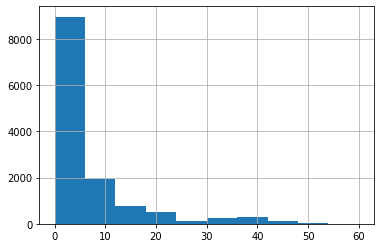

In [10]:
aes_df.total_score.hist()

In [11]:
aes_essays = aes_df.query("total_score > 1")["essay"].values.tolist()

In [12]:
def cleanAES(dataList):
    newList = []
    for sent in dataList:
        sent = re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)', '', sent)
        sent = sent.replace("\\","")
        sent = sent.replace("\\'","")
        sent = sent.strip().strip("'").strip('"')

        if len(sent) < 40:
            continue
        if '^' in sent:
            continue
        
        sent = ' '.join(sent.split())
        sent = sent.lower()#.decode('utf8', 'ignore')
        newList.append(sent + '\n')
    
    return newList

In [13]:
clean_aes = cleanAES(aes_essays)

In [150]:

d.check("league")

True

In [14]:
# from spellchecker import SpellChecker

# spell = SpellChecker()

d_check = lambda sent: map(lambda x: d.check(x), word_tokenize(sent))
split_aes = []
for essay in tqdm(clean_aes):
    split_up = sent_tokenize(essay)
    for sent in split_up:
        words = word_tokenize(sent)
        if not all(list(d_check(sent))):
            continue
        if len(words) > 30:
            continue
        if len(words) < 4:
            continue
        split_aes.append(sent+'\n')

100%|██████████| 10826/10826 [01:46<00:00, 101.41it/s]


In [456]:

# list(map(lambda x: d_check, split_aes[0:100]))


False

In [152]:
word_tokenize(split_aes[0])

['how',
 'would',
 'you',
 'feel',
 'if',
 'your',
 'teenager',
 'is',
 'always',
 'on',
 'the',
 'phone',
 'with',
 'friends',
 '!']

In [154]:
with open("/Users/spencerbraun/Documents/Stanford/CS 230 - Deep Learning/Project/CS_230_Project/data/processed/aes.txt", 'w') as f:
    f.writelines(split_aes)

In [153]:
len(split_aes)

84373

### Hewlett AES  - Keep tokens in

In [9]:

aes_file = "/Users/spencerbraun/Documents/Stanford/CS 230 - Deep Learning/Project/CS_230_Project/data/raw/asap-aes/training_set_rel3.tsv"
aes_list = [] 
with open(aes_file, encoding='utf-8', errors='ignore') as f:
    for line in f:
        aes_list.append(line.strip().split('\t'))
        
aes_df = pd.DataFrame(aes_list[1:], columns=aes_list[0])    
num_cols = ['rater1_domain1', 'rater2_domain1',
       'rater3_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2',
       'domain2_score']

aes_df[num_cols] = aes_df[num_cols].applymap(lambda x: np.nan if (x == "") or (x is None) else int(x))
aes_df["total_score"] = (aes_df["domain1_score"] + aes_df["domain2_score"].fillna(aes_df["domain1_score"]))/2

In [11]:
aes_essays = aes_df.query("total_score > 1")["essay"].values.tolist()

In [41]:
token_list = []
new_strings = []
for string in aes_essays:
    matches = re.findall(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[0-9]+)', string)
    token_list.extend(list(set(matches)))
    
    string = string.replace('@' , '')
    replacement = {x: "<" + re.sub('[0-9]', '', x) + ">" for x in matches}
    for match in matches:
        string = string.replace(match, replacement[match])
    new_strings.append(string)

In [ ]:
list(set([re.sub('[0-9]', '', x) for x in token_list]))

In [45]:
from nltk.tag import StanfordNERTagger

['MONTH',
 'NUM',
 'DR',
 'DATE',
 'LOCATION',
 'STATE',
 'CITY',
 'TIME',
 'MONEY',
 'ORGANIZATION',
 'PERCENT',
 'PERSON',
 'CAPS']

In [ ]:
def cleanAES(dataList):
    newList = []
    for sent in dataList:
        sent = re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)', '', sent)
        sent = sent.replace("\\","")
        sent = sent.replace("\\'","")
        sent = sent.strip().strip("'").strip('"')

        if len(sent) < 40:
            continue
        if '^' in sent:
            continue
        
        sent = ' '.join(sent.split())
        sent = sent.lower()#.decode('utf8', 'ignore')
        newList.append(sent + '\n')
    
    return newList

In [ ]:

d_check = lambda sent: map(lambda x: d.check(x), word_tokenize(sent))
split_aes = []
for essay in tqdm(clean_aes):
    split_up = sent_tokenize(essay)
    for sent in split_up:
        words = word_tokenize(sent)
        if not all(list(d_check(sent))):
            continue
        if len(words) > 30:
            continue
        if len(words) < 4:
            continue
        split_aes.append(sent+'\n')

### Sophisticated Writing - Project Gutenberg

In [18]:
secondCorpus = [
    "https://ota.bodleian.ox.ac.uk/repository/xmlui/bitstream/handle/20.500.12024/1906/cardinal-1906.txt?sequence=3&isAllowed=y",
    "https://ota.bodleian.ox.ac.uk/repository/xmlui/bitstream/handle/20.500.12024/1658/WoolfWaves-1658.txt?sequence=4&isAllowed=y",
    "https://ota.bodleian.ox.ac.uk/repository/xmlui/bitstream/handle/20.500.12024/0172/moderns-0172.txt?sequence=4&isAllowed=y",
    "https://ota.bodleian.ox.ac.uk/repository/xmlui/bitstream/handle/20.500.12024/3246/3246.txt?sequence=8&isAllowed=y",
    "https://ota.bodleian.ox.ac.uk/repository/xmlui/bitstream/handle/20.500.12024/2042/joywoman-2042.txt?sequence=4&isAllowed=y",
    "https://ota.bodleian.ox.ac.uk/repository/xmlui/bitstream/handle/20.500.12024/3135/3135.txt?sequence=8&isAllowed=y",
    "https://ota.bodleian.ox.ac.uk/repository/xmlui/bitstream/handle/20.500.12024/1711/wiseman-1711.txt?sequence=4&isAllowed=y",
    "https://ota.bodleian.ox.ac.uk/repository/xmlui/bitstream/handle/20.500.12024/3245/3245.txt?sequence=8&isAllowed=y",
    "http://www.gutenberg.org/cache/epub/5827/pg5827.txt", #Russell, The Problems of Philosophy
    "http://www.gutenberg.org/cache/epub/15718/pg15718.txt", #Bleyer, How To Write Special Feature Articles
    "https://www.gutenberg.org/files/492/492-0.txt", #Essays in the Art of Writing, by Robert Louis
    "https://www.gutenberg.org/files/37090/37090-0.txt", #Our Knowledge of the External World as a Field for Scientific Method in Philosoph, by Bertrand Russell
    "https://www.gutenberg.org/files/42580/42580-8.txt", #Expository Writing, by Mervin James Curl
    "http://www.gutenberg.org/cache/epub/2529/pg2529.txt", #The Analysis of Mind, by Bertrand Russell
    "https://www.gutenberg.org/files/38280/38280-0.txt",
    "https://www.gutenberg.org/files/215/215-0.txt", # London, call of the wild.
    "http://www.gutenberg.org/cache/epub/910/pg910.txt",
    "https://www.gutenberg.org/files/25110/25110-0.txt",
    "http://www.gutenberg.org/cache/epub/32168/pg32168.txt",
    "http://www.gutenberg.org/cache/epub/16712/pg16712.txt",
    "http://www.gutenberg.org/cache/epub/7514/pg7514.txt",
    "http://www.gutenberg.org/cache/epub/18477/pg18477.txt",
    "http://www.gutenberg.org/cache/epub/5669/pg5669.txt",
    "http://www.gutenberg.org/cache/epub/5123/pg5123.txt",
    "http://www.gutenberg.org/cache/epub/10378/pg10378.txt",
    "https://www.gutenberg.org/files/140/140-0.txt",
    "http://www.gutenberg.org/cache/epub/44082/pg44082.txt"
]

In [19]:
firstCorpus = [
    "http://www.gutenberg.org/cache/epub/5827/pg5827.txt", #Russell, The Problems of Philosophy
    "http://www.gutenberg.org/cache/epub/15718/pg15718.txt", #Bleyer, How To Write Special Feature Articles
    "https://www.gutenberg.org/files/492/492-0.txt", #Essays in the Art of Writing, by Robert Louis
    "https://www.gutenberg.org/files/37090/37090-0.txt", #Our Knowledge of the External World as a Field for Scientific Method in Philosoph, by Bertrand Russell
    "https://www.gutenberg.org/files/42580/42580-8.txt", #Expository Writing, by Mervin James Curl
    "http://www.gutenberg.org/cache/epub/2529/pg2529.txt", #The Analysis of Mind, by Bertrand Russell
    "https://www.gutenberg.org/files/38280/38280-0.txt", #Modern Essays, by Various
    "https://www.gutenberg.org/files/205/205-0.txt", #Walden, and On The Duty Of Civil Disobedience, by Henry David Thoreau
    "https://www.gutenberg.org/files/1022/1022-0.txt", #Walking, by Henry David Thoreau
    "http://www.gutenberg.org/cache/epub/34901/pg34901.txt",
    "https://www.gutenberg.org/files/98/98-0.txt",
    "http://www.gutenberg.org/cache/epub/32168/pg32168.txt",
    "https://www.gutenberg.org/files/766/766-0.txt",
    "https://www.gutenberg.org/files/1250/1250-0.txt",
    "https://www.gutenberg.org/files/140/140-0.txt",
    "https://www.gutenberg.org/files/1400/1400-0.txt",
    "https://www.gutenberg.org/files/215/215-0.txt", # London, call of the wild.
    "http://www.gutenberg.org/cache/epub/910/pg910.txt", #London White Fang
    "https://www.gutenberg.org/files/786/786-0.txt",
    "http://www.gutenberg.org/cache/epub/815/pg815.txt",
    "http://www.gutenberg.org/cache/epub/10378/pg10378.txt",
    "http://www.gutenberg.org/cache/epub/5123/pg5123.txt",
    "http://www.gutenberg.org/cache/epub/5669/pg5669.txt"
]


In [20]:
def filterSentences(sentList):
    filteredList = []
    for sent in sentList:
        sent = sent.replace("\\","")
        sent = sent.replace("\\'","")


        if len(sent) < 40:
            continue
        if '^' in sent:
            continue
        if bool(re.search(r'\d', sent)):
            continue
        if bool(re.search(r"\b[A-Z][A-Z]+\b", sent)):
            continue
        if bool(re.search(r'\"', sent)):
            continue
        if bool(re.search(r'_', sent)):
            continue

        sent = sent.strip()
        sent = sent.lower()
        sent = ' '.join(sent.split())
        filteredList.append(sent + '\n')

    return filteredList

In [21]:
def readCorpus(url):
    content = requests.get(url).content.decode('ascii', 'ignore')
    content_list = sent_tokenize(content.replace('\r\n', ' '))
    
    filtered_list = filterSentences(content_list)
    
    return filtered_list[100:]

In [66]:
allGuten = []
for url in firstCorpus:
    allGuten.append(readCorpus(url))

In [67]:
len(allGuten)

23

In [68]:
sum([len(x) for x in allGuten])

69955

In [69]:
allSophs = [y for x in allGuten for y in x]

In [375]:
with open("/Users/spencerbraun/Documents/Stanford/CS 230 - Deep Learning/Project/CS_230_Project/data/processed/allsophs.txt", 'w') as f:
    f.writelines(allSophs)

In [ ]:
with open("/Users/spencerbraun/Documents/Stanford/CS 230 - Deep Learning/Project/CS_230_Project/data/processed/allsophs.txt", 'r') as f:
    allSophs = f.read_lines

### Using Second Corpus

In [22]:
allSecondCorpus = []
for url in secondCorpus:
    allSecondCorpus.append(readCorpus(url))

In [23]:
sum([len(x) for x in allSecondCorpus])

51291

In [118]:
allSophs = [y for x in allSecondCorpus for y in x]

### Without Punctuation

In [24]:
punctSoph = [y for x in allSecondCorpus for y in x]

In [65]:
def removePunc(sent):
    sent = re.sub('['+string.punctuation+']', '', sent)
    sent = ' '.join(sent.split())
    return(sent + '\n')

In [66]:
allSophs = list(map(removePunc, punctSoph))

In [68]:
with open("/Users/spencerbraun/Documents/Stanford/CS 230 - Deep Learning/Project/CS_230_Project/data/processed/KMW_essays.txt", 'r') as f:
    kmw = f.readlines()
with open("/Users/spencerbraun/Documents/Stanford/CS 230 - Deep Learning/Project/CS_230_Project/data/processed/aes.txt", 'r') as f:
    split_aes = f.readlines()

In [69]:
allnaive = kmw + split_aes[0:50000]

In [70]:
allnaive = list(map(removePunc, allnaive))

In [71]:
allnaive[100:130]

['but people can also contribute at individual level by planting trees and preventing denudation of vegetable cover\n',
 'unemployment is a great curse\n',
 'it brings to the surface the evil side of human nature\n',
 'government has to keep an eye on the unemployed and to keep their numbers down\n',
 'it has opened employment exchanges in all cities\n',
 'the unemployed are required to register with these\n',
 'whenever there is a vacancy suitable to their qualifications they are considered for it\n',
 'number of unemployed is rising fast\n',
 'there is always a great rush at the windows\n',
 'the clerks take their own time in verifying and registering\n',
 'restless people can be seen standing helplessly in queues for long hours\n',
 'they have to join the other queue and are again at the fag end\n',
 'quite often by the time their turn come it is time for closing\n',
 'they have to go jump to come another day\n',
 'though there are so many people yet no cheerful voices are heard\n',

### Select Data

In [76]:

keepshort = []
for sent in allSophs:
    words = len(word_tokenize(sent))
    if words <= 30:
        keepshort.append(sent)

In [77]:
len(keepshort)

37211

In [78]:
keepnum = 33408

In [79]:
split1 = int(keepnum * 0.05)
remain = split1 % 128
split1 += remain

In [80]:
import random
from collections import defaultdict


random.seed(123)

random.shuffle(keepshort)
selectedSophs = keepshort[0:keepnum]
sophstrain = selectedSophs[split1:]
sophtest = selectedSophs[0:split1]
print(len(sophtest))
print(len(sophstrain))
with open("/Users/spencerbraun/Documents/Stanford/CS 230 - Deep Learning/Project/CS_230_Project/data/processed/soph_test_3.txt", 'w') as f:
    f.writelines(sophtest)
with open("/Users/spencerbraun/Documents/Stanford/CS 230 - Deep Learning/Project/CS_230_Project/data/processed/soph_train_3.txt", 'w') as f:
    f.writelines(sophstrain)

1676
31732


In [126]:
len(sophtest) + len(sophstrain)

33408

In [ ]:
split_aes

In [46]:
with open("/Users/spencerbraun/Documents/Stanford/CS 230 - Deep Learning/Project/CS_230_Project/data/processed/KMW_essays.txt", 'r') as f:
    kmw = f.readlines()
with open("/Users/spencerbraun/Documents/Stanford/CS 230 - Deep Learning/Project/CS_230_Project/data/processed/aes.txt", 'r') as f:
    split_aes = f.readlines()

In [47]:
allnaive = kmw + split_aes[0:50000]

In [48]:
len(allnaive)

53759

In [72]:
allnaive = [x for x in allnaive if len(x) > 20]
naiveshort = []
for sent in allnaive:
    words = len(word_tokenize(sent))
    if words <= 25:
        naiveshort.append(sent)

In [73]:
len(naiveshort)

50895

In [74]:
naiveshort[15500:15520]

['since computers have become such a popular thing i think that in the future typing or using a computer will be in the\n',
 'do you have picture files laying your house\n',
 'with computers you store all and files neatly\n',
 'how your might you can bark those easy to find everything becomes all that are locate\n',
 'even doctors are computers your medical needs and give time\n',
 'computers can give organize\n',
 'furthermore computers continue to help instead with store say keep friends i can talk with friends or family far away\n',
 'you can learn about new things like people and places far away\n',
 'kids try to learn people talk like websites things that they are not able to and over they can see are on\n',
 'dear a world without computers\n',
 'i picture it as a better place\n',
 'computers be helpful for work and business but young children are losing time to exercise enjoy nature and interact with family and friends\n',
 'what do you prefer having computers or no\n',
 'in my o

In [75]:
random.seed(123)
random.shuffle(allnaive)
selectedNaive = allnaive[0:keepnum]
naivetrain = selectedNaive[split1:]
naivetest = selectedNaive[0:split1]
print(len(naivetest))
print(len(naivetrain))
print(len(naivetrain) + len(naivetest))
with open("/Users/spencerbraun/Documents/Stanford/CS 230 - Deep Learning/Project/CS_230_Project/data/processed/naive_test_3.txt", 'w') as f:
    f.writelines(naivetest)
with open("/Users/spencerbraun/Documents/Stanford/CS 230 - Deep Learning/Project/CS_230_Project/data/processed/naive_train_3.txt", 'w') as f:
    f.writelines(naivetrain)

1676
31732
33408


In [432]:
len(counter)

1181